# Will Bank's Clients subscribe to term deposit? Comparing results from different classification methods.

Data set comes from https://www.kaggle.com/ishandutta/bank-marketing-data-set, description of the dataset:

The data is related to direct marketing campaigns of a Portuguese banking institution. 
The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, 
in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 
The classification goal => predict if the client will subscribe to a term deposit.

#### Imports 

In [1]:
import custmetrics as cust
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest

#### Reading data 

In [2]:
bank_data = pd.read_csv('/Users/user/Desktop/Python/Classification Project/bank-additional-full.csv',sep = ';')
#Checking how data looks like in general, how much data is there and what are the columns names
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
#Changing columns names, so that they are more intuitive
bank_data.columns = ['age', 'job_type', 'marital', 'education', 'has_credit', 'has_house_loan', 'has_person_loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pass_days',
       'previous', 'prev_outcome', 'emp_var_rate', 'cpi',
       'cci', 'euribor3m', 'nr_employed', 'class']
#Based on the info from the site we narrow down number of features
bank_data_min = bank_data[['job_type', 'marital', 'education', 'has_credit', 'has_house_loan',
                          'has_person_loan','contact', 'prev_outcome', 'age', 'campaign', 'previous',
                          'emp_var_rate', 'cpi','cci', 'euribor3m', 'class']]
bank_data_min.describe()

,age,campaign,previous,emp_var_rate,cpi,cci,euribor3m
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,0.172963,0.081886,93.575664,-40.502600,3.621291
std,10.42125,2.770014,0.494901,1.570960,0.578840,4.628198,1.734447
min,17.00000,1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000
25%,32.00000,1.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000
50%,38.00000,2.000000,0.000000,1.100000,93.749000,-41.800000,4.857000
75%,47.00000,3.000000,0.000000,1.400000,93.994000,-36.400000,4.961000
max,98.00000,56.000000,7.000000,1.400000,94.767000,-26.900000,5.045000


In [4]:
y = bank_data_min.iloc[:,-1].values
X = bank_data_min.iloc[:,:-1].values

#### Handling missing data

In [5]:
bank_data_min.iloc[:,:-1].isnull().any(axis=1).unique()
#No missing data detected

array([False])

In [6]:
bank_data_min.iloc[:,:-1]

,job_type,marital,education,has_credit,has_house_loan,has_person_loan,contact,prev_outcome,age,campaign,previous,emp_var_rate,cpi,cci,euribor3m
0,housemaid,married,basic.4y,no,no,no,telephone,nonexistent,56,1,0,1.1,93.994,-36.4,4.857
1,services,married,high.school,unknown,no,no,telephone,nonexistent,57,1,0,1.1,93.994,-36.4,4.857
2,services,married,high.school,no,yes,no,telephone,nonexistent,37,1,0,1.1,93.994,-36.4,4.857
3,admin.,married,basic.6y,no,no,no,telephone,nonexistent,40,1,0,1.1,93.994,-36.4,4.857
4,services,married,high.school,no,no,yes,telephone,nonexistent,56,1,0,1.1,93.994,-36.4,4.857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,no,yes,no,cellular,nonexistent,73,1,0,-1.1,94.767,-50.8,1.028
41184,blue-collar,married,professional.course,no,no,no,cellular,nonexistent,46,1,0,-1.1,94.767,-50.8,1.028
41185,retired,married,university.degree,no,yes,no,cellular,nonexistent,56,2,0,-1.1,94.767,-50.8,1.028
41186,technician,married,professional.course,no,no,no,cellular,nonexistent,44,1,0,-1.1,94.767,-50.8,1.028


#### Encoding categorical data 

In [7]:
#X - using One Hot Encoder
X_b4_encode = bank_data_min.iloc[:,:-1].values
ohe = OneHotEncoder()
col_trans = ColumnTransformer(transformers= [('encoder',ohe,[0,1,2,3,4,5,6,7])])
X_b4_encode = col_trans.fit_transform(X_b4_encode)

#Adding name columns to processed data
X_b4_encode = pd.DataFrame(X_b4_encode.toarray())
name_list = [string.replace("encoder__","") for string in col_trans.get_feature_names()]
var_encoder = {'x0': 'job_type', 'x1': 'marital', 'x2': 'education', 'x3': 'has_credit', 'x4': 'has_house_loan', \
               'x5': 'has_person_loan', 'x6': 'contact', 'x7': 'prev_outcome'}
name_list = [string.replace(string[:2],var_encoder[string[:2]]) for string in name_list]
X_b4_encode.columns = name_list

X = pd.concat([X_b4_encode,pd.DataFrame(X[:,8:])],axis=1)
name_list.extend(['age', 'campaign', 'previous', 'emp_var_rate', 'cpi','cci', 'euribor3m'])
X.columns = name_list

In [8]:
#y - using Label Encoder
le = LabelEncoder()
y = le.fit_transform(y)

#### Splitting test and train dataset

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### Scaling data

In [10]:
sc = StandardScaler()
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train[:,38:] = sc.fit_transform(X_train[:,38:])
X_test[:,38:] = sc.transform(X_test[:,38:])

#### Feature selection 

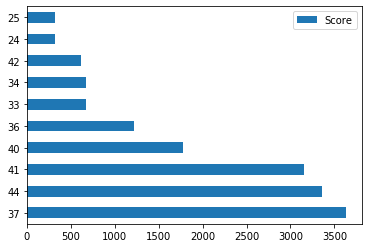

In [11]:
bestfeatures = SelectKBest(k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores.nlargest(10,'Score').plot(kind='barh')
plt.show()

In [12]:
X_train_fs = X_train[:,[25,24,42,34,33,36,40,41,44,37]]
X_test_fs = X_test[:,[25,24,42,34,33,36,40,41,44,37]]

### Classifier for Logistic Regression

In [13]:
classifierLR = LogisticRegression(C = 1, max_iter=1000,random_state=0)
classifierLR.fit(X_train_fs,y_train)
y_pred_lr = classifierLR.predict(X_test_fs)

In [14]:
#Calculating accuracy scores
probs_lr = classifierLR.predict_proba(X_test_fs)[:,1]
scores_lr = cust.calc_acc(probs_lr, X_test_fs, y_pred_lr, y_test, 'Log_Reg')

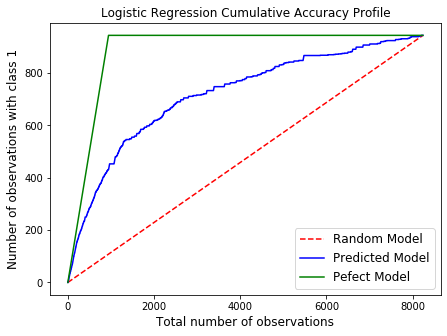

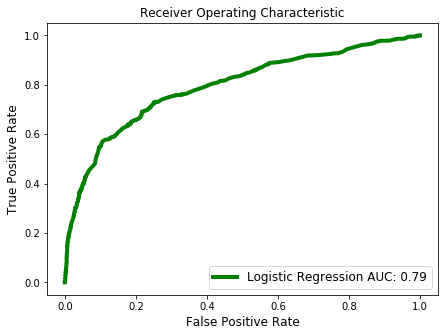

In [15]:
#Drawing CAP and ROC Curves
cust.draw_all(probs_lr, y_test, "Logistic Regression")

In [16]:
#Print scores as DataFrame
scores_df = pd.DataFrame(scores_lr)
scores_df.columns = ['Name', 'Acc_Rate', 'CAP_Score', 'ROC_Score', 'Brier_Score', 'Log_Loss_Score']
scores_df

,Name,Acc_Rate,CAP_Score,ROC_Score,Brier_Score,Log_Loss_Score
0,Log_Reg,0.897,0.591,0.793,0.082,0.286


### Elbow Method

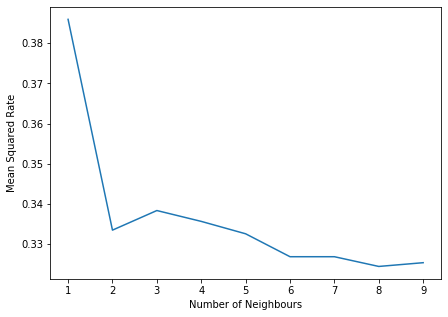

In [17]:
cust.draw_errors_knn(X_train_fs, y_train, X_test_fs, y_test)

### K-Neighbours Classifier

In [18]:
#I have decided to use k=8. Since the elbow method is not smooth enough,
#I have checked on the side which one will give best accuracy and this is the one.
k_neighbors = 8
classifierKNN = KNeighborsClassifier(n_neighbors = k_neighbors, metric = 'minkowski', p=2)

In [19]:
classifierKNN.fit(X_train_fs, y_train)
y_pred_knn = classifierKNN.predict(X_test_fs)

In [20]:
#Calculating accuracy scores
probs_knn = classifierKNN.predict_proba(X_test_fs)[:,1]
scores_knn = cust.calc_acc(probs_knn, X_test_fs, y_pred_knn, y_test, 'K-NN')

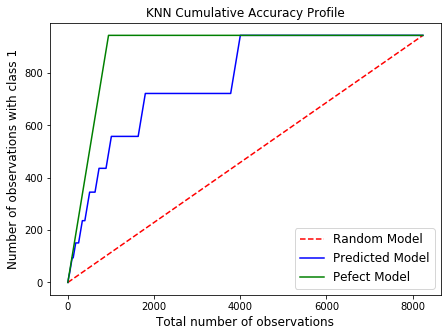

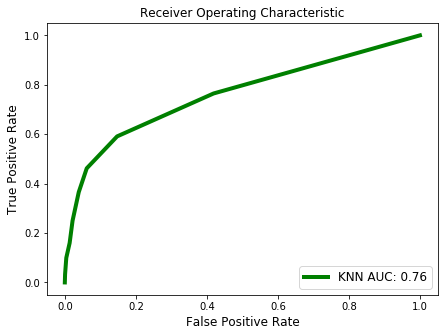

In [21]:
#Drawing CAP and ROC Curves
cust.draw_all(probs_knn, y_test, "KNN")

In [22]:
#Add scores to DataFrame
scores_knn = pd.DataFrame(scores_knn)
scores_knn.columns = ['Name', 'Acc_Rate', 'CAP_Score', 'ROC_Score', 'Brier_Score', 'Log_Loss_Score']
scores_df = scores_df.append(pd.DataFrame(scores_knn), ignore_index=True)
scores_df

,Name,Acc_Rate,CAP_Score,ROC_Score,Brier_Score,Log_Loss_Score
0,Log_Reg,0.897,0.591,0.793,0.082,0.286
1,K-NN,0.895,0.720,0.760,0.086,1.141


### Support Vector Machine Classifier

#### Linear RBF SVM

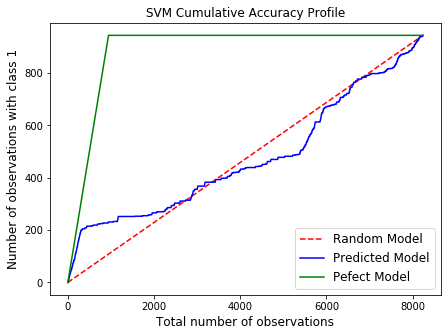

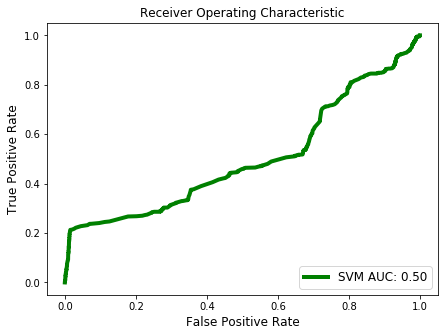

In [23]:
classifierSVM = SVC(kernel = 'linear', random_state = 0, probability = True)
classifierSVM.fit(X_train_fs, y_train)
y_pred_svm = classifierSVM.predict(X_test_fs)
probs_svm = classifierSVM.predict_proba(X_test_fs)[:,1]
scores_svm = cust.calc_acc(probs_svm, X_test_fs, y_pred_svm, y_test, 'SVM')
cust.draw_all(probs_svm, y_test, "SVM")

In [24]:
#Add scores to DataFrame
scores_svm = pd.DataFrame(scores_svm)
scores_svm.columns = ['Name', 'Acc_Rate', 'CAP_Score', 'ROC_Score', 'Brier_Score', 'Log_Loss_Score']
scores_df = scores_df.append(pd.DataFrame(scores_svm), ignore_index=True)
scores_df

,Name,Acc_Rate,CAP_Score,ROC_Score,Brier_Score,Log_Loss_Score
0,Log_Reg,0.897,0.591,0.793,0.082,0.286
1,K-NN,0.895,0.720,0.760,0.086,1.141
2,SVM,0.896,0.005,0.500,0.091,0.326


#### RBF SVM

In [25]:
classifierSVMR = SVC(kernel = 'rbf', random_state = 0, probability = True)
classifierSVMR.fit(X_train_fs, y_train)
y_pred_svm_rbf = classifierSVMR.predict(X_test_fs)

In [26]:
#Calculating accuracy scores
probs_svm_rbf = classifierSVMR.predict_proba(X_test_fs)[:,1]
scores_svm_rbf = cust.calc_acc(probs_svm_rbf, X_test_fs, y_pred_svm_rbf, y_test, 'SVM_RBF')

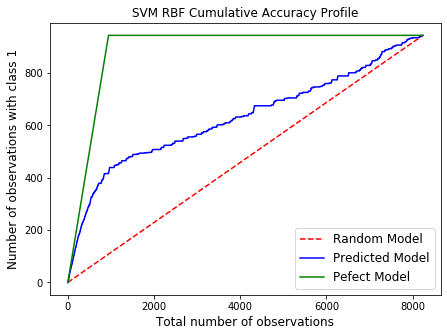

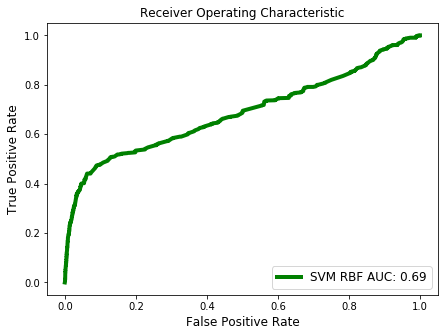

In [27]:
#Drawing CAP and ROC Curves
cust.draw_all(probs_svm_rbf, y_test, "SVM RBF")

In [28]:
#Add scores to DataFrame
scores_svm_rbf = pd.DataFrame(scores_svm_rbf)
scores_svm_rbf.columns = ['Name', 'Acc_Rate', 'CAP_Score', 'ROC_Score', 'Brier_Score', 'Log_Loss_Score']
scores_df = scores_df.append(pd.DataFrame(scores_svm_rbf), ignore_index=True)
scores_df

,Name,Acc_Rate,CAP_Score,ROC_Score,Brier_Score,Log_Loss_Score
0,Log_Reg,0.897,0.591,0.793,0.082,0.286
1,K-NN,0.895,0.720,0.760,0.086,1.141
2,SVM,0.896,0.005,0.500,0.091,0.326
3,SVM_RBF,0.899,0.377,0.686,0.087,0.314


### Naive Bayes Classifier

In [29]:
classifierNB = GaussianNB()
classifierNB.fit(X_train_fs,y_train)
y_pred_nb = classifierNB.predict(X_test_fs)

In [30]:
#Calculating accuracy scores
probs_nb = classifierNB.predict_proba(X_test_fs)[:,1]
scores_nb = cust.calc_acc(probs_nb, X_test_fs, y_pred_nb, y_test, 'Naive_B')

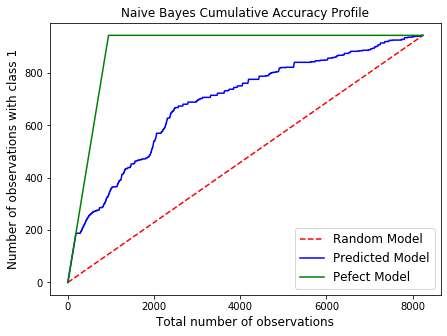

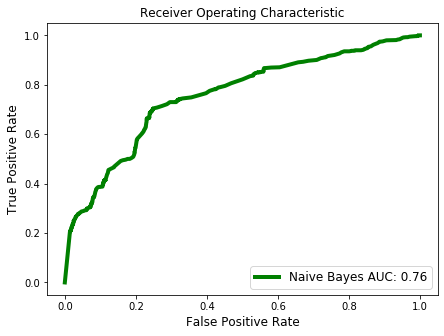

In [31]:
#Drawing CAP and ROC Curves
cust.draw_all(probs_nb, y_test, "Naive Bayes")

In [32]:
#Add scores to DataFrame
scores_nb = pd.DataFrame(scores_nb)
scores_nb.columns = ['Name', 'Acc_Rate', 'CAP_Score', 'ROC_Score', 'Brier_Score', 'Log_Loss_Score']
scores_df = scores_df.append(pd.DataFrame(scores_nb), ignore_index=True)
scores_df

,Name,Acc_Rate,CAP_Score,ROC_Score,Brier_Score,Log_Loss_Score
0,Log_Reg,0.897,0.591,0.793,0.082,0.286
1,K-NN,0.895,0.720,0.760,0.086,1.141
2,SVM,0.896,0.005,0.500,0.091,0.326
3,SVM_RBF,0.899,0.377,0.686,0.087,0.314
4,Naive_B,0.831,0.520,0.756,0.148,1.158


### Decision Tree Classifier 

In [33]:
classifierDTC = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifierDTC.fit(X_train_fs,y_train)
y_pred_dtc = classifierDTC.predict(X_test_fs)

In [34]:
#Calculating accuracy scores
probs_dtc = classifierDTC.predict_proba(X_test_fs)[:,1]
scores_dtc = cust.calc_acc(probs_dtc, X_test_fs, y_pred_dtc, y_test, 'DT')

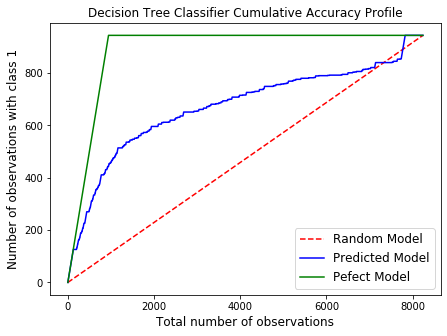

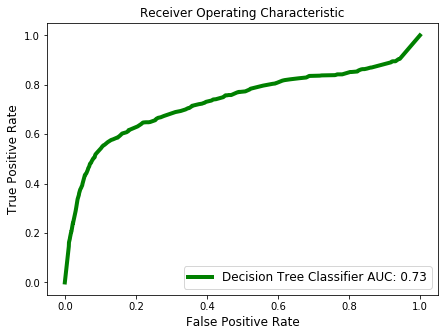

In [35]:
#Drawing CAP and ROC Curves
cust.draw_all(probs_dtc, y_test, "Decision Tree Classifier")

In [36]:
#Add scores to DataFrame
scores_dtc = pd.DataFrame(scores_dtc)
scores_dtc.columns = ['Name', 'Acc_Rate', 'CAP_Score', 'ROC_Score', 'Brier_Score', 'Log_Loss_Score']
scores_df = scores_df.append(pd.DataFrame(scores_dtc), ignore_index=True)
scores_df

,Name,Acc_Rate,CAP_Score,ROC_Score,Brier_Score,Log_Loss_Score
0,Log_Reg,0.897,0.591,0.793,0.082,0.286
1,K-NN,0.895,0.720,0.760,0.086,1.141
2,SVM,0.896,0.005,0.500,0.091,0.326
3,SVM_RBF,0.899,0.377,0.686,0.087,0.314
4,Naive_B,0.831,0.520,0.756,0.148,1.158
5,DT,0.892,0.477,0.732,0.088,0.930


### Random Forest Classifier 

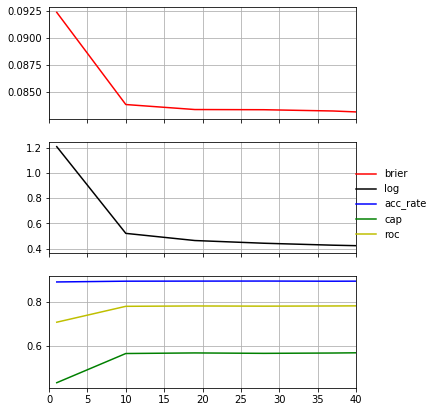

In [37]:
#Draw accuracy scores for different number of estimators for Random Forest Classifier
rf_scores = cust.rf_scores(X_train_fs, y_train, X_test_fs, y_test)
cust.rf_draw_scores(rf_scores)

In [38]:
classifierRFC = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifierRFC.fit(X_train_fs,y_train)
y_pred_rfc = classifierRFC.predict(X_test_fs)

In [39]:
#Calculating accuracy scores
probs_rfc = classifierRFC.predict_proba(X_test_fs)[:,1]
scores_rfc = cust.calc_acc(probs_rfc, X_test_fs, y_pred_rfc, y_test, 'RF')

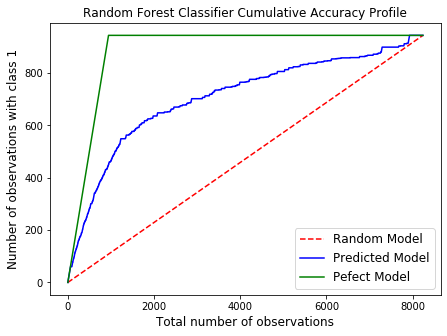

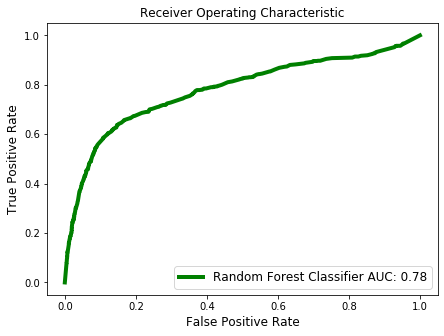

In [40]:
#Drawing CAP and ROC Curves
cust.draw_all(probs_rfc, y_test, "Random Forest Classifier")

In [41]:
#Add scores to DataFrame
scores_rfc = pd.DataFrame(scores_rfc)
scores_rfc.columns = ['Name', 'Acc_Rate', 'CAP_Score', 'ROC_Score', 'Brier_Score', 'Log_Loss_Score']
scores_df = scores_df.append(pd.DataFrame(scores_rfc), ignore_index=True)
scores_df

,Name,Acc_Rate,CAP_Score,ROC_Score,Brier_Score,Log_Loss_Score
0,Log_Reg,0.897,0.591,0.793,0.082,0.286
1,K-NN,0.895,0.720,0.760,0.086,1.141
2,SVM,0.896,0.005,0.500,0.091,0.326
3,SVM_RBF,0.899,0.377,0.686,0.087,0.314
4,Naive_B,0.831,0.520,0.756,0.148,1.158
5,DT,0.892,0.477,0.732,0.088,0.930
6,RF,0.893,0.564,0.779,0.084,0.521


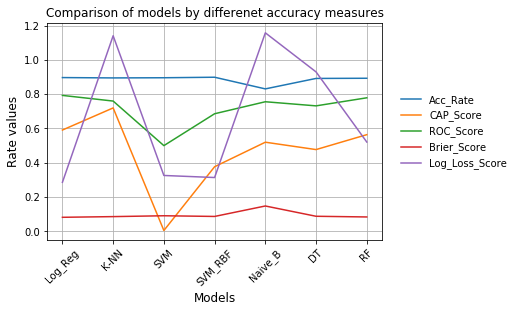

In [42]:
plt.plot(scores_df['Name'],scores_df[['Acc_Rate', 'CAP_Score', 'ROC_Score', 'Brier_Score', 'Log_Loss_Score']], )
plt.grid(axis ='both')
plt.legend(scores_df.columns[1:], loc = 'center right', bbox_to_anchor = (1.40,0.5), frameon = False)
plt.xticks(rotation=45)
plt.xlabel('Models', fontsize = 12)
plt.ylabel('Rate values', fontsize = 12)
plt.title('Comparison of models by differenet accuracy measures', fontsize = 12)
plt.show()

In [43]:
#We rejecr KNN, Decusion Tree and Naive Baies due to high log loss score
#SVM is rejected because of low CAP Score
scores_df_new = scores_df.iloc[[0,3,6],:]

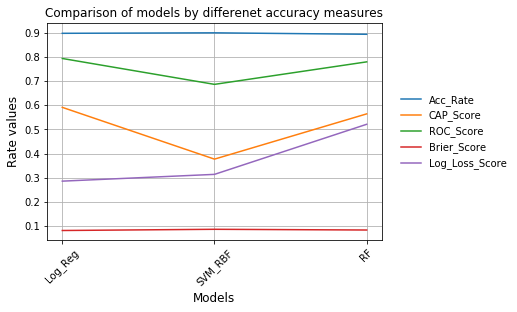

In [44]:
plt.plot(scores_df_new['Name'],scores_df_new[['Acc_Rate', 'CAP_Score', 'ROC_Score', 'Brier_Score', 'Log_Loss_Score']], )
plt.grid(axis ='both')
plt.legend(scores_df_new.columns[1:], loc = 'center right', bbox_to_anchor = (1.40,0.5), frameon = False)
plt.xticks(rotation=45)
plt.xlabel('Models', fontsize = 12)
plt.ylabel('Rate values', fontsize = 12)
plt.title('Comparison of models by differenet accuracy measures', fontsize = 12)
plt.show()

# Logistic Regression Classifier is the best one.